# POG Raw Output Comparison - All 8 Videos

Compare raw POG model outputs (pog_x_cm, pog_y_cm) from our YOLO+POG pipeline vs original parquet predictions.

- **Session 1 (0014c300)**: 4 calibration videos
- **Session 2 (0132028e)**: 4 calibration videos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

POG_DIR = Path('/media/a/saw/pog')
OUT_DIR = Path('/media/a/saw/pogclaude')

# Load original parquets
df1_orig = pd.read_parquet(POG_DIR / '0014c300-76ca-456e-9ada-89db12_calibration_with_pog_cm.parquet')
df2_orig = pd.read_parquet(POG_DIR / '0132028e-95b1-4f9e-bdd6-1ddc9a_calibration_with_pog_cm.parquet')

# Get unique video paths
s1_videos = df1_orig['video_path'].unique()
s2_videos = df2_orig['video_path'].unique()

print(f'Session 1: {len(s1_videos)} videos')
print(f'Session 2: {len(s2_videos)} videos')

Session 1: 4 videos
Session 2: 4 videos


## Load New Predictions

In [2]:
# Load all new predictions
new_preds = {}
for i in range(1, 5):
    new_preds[f's1_v{i}'] = pd.read_parquet(POG_DIR / f'videos/s1_v{i}_pog.parquet')
    new_preds[f's2_v{i}'] = pd.read_parquet(POG_DIR / f'videos/s2_v{i}_pog.parquet')

# Show counts
print('New prediction frame counts:')
for k, v in new_preds.items():
    print(f'  {k}: {len(v)} frames')

New prediction frame counts:
  s1_v1: 1850 frames
  s2_v1: 1851 frames
  s1_v2: 1858 frames
  s2_v2: 1859 frames
  s1_v3: 1855 frames
  s2_v3: 1855 frames
  s1_v4: 1855 frames
  s2_v4: 1853 frames


## Merge Original and New Predictions

In [3]:
def merge_video_predictions(df_orig, video_path, df_new, video_name):
    """Merge original and new predictions for a single video."""
    # Filter original to this video
    orig = df_orig[df_orig['video_path'] == video_path].copy()
    orig = orig.dropna(subset=['frame_index'])
    orig['frame'] = orig['frame_index'].astype(int)
    
    # Keep only relevant columns
    orig_slim = orig[['frame', 'pog_x_cm', 'pog_y_cm']].copy()
    orig_slim = orig_slim.rename(columns={'pog_x_cm': 'orig_x', 'pog_y_cm': 'orig_y'})
    
    # Prepare new predictions
    new = df_new.copy()
    new = new.rename(columns={'pog_x_cm': 'new_x', 'pog_y_cm': 'new_y'})
    
    # Merge
    merged = orig_slim.merge(new[['frame', 'new_x', 'new_y']], on='frame', how='outer')
    merged['video'] = video_name
    
    # Compute differences
    merged['diff_x'] = merged['new_x'] - merged['orig_x']
    merged['diff_y'] = merged['new_y'] - merged['orig_y']
    merged['diff_euclidean'] = np.sqrt(merged['diff_x']**2 + merged['diff_y']**2)
    
    return merged

# Merge all videos
all_merged = []

# Session 1
for i, vpath in enumerate(s1_videos):
    vname = f's1_v{i+1}'
    merged = merge_video_predictions(df1_orig, vpath, new_preds[vname], vname)
    all_merged.append(merged)
    print(f'{vname}: {len(merged)} frames merged')

# Session 2
for i, vpath in enumerate(s2_videos):
    vname = f's2_v{i+1}'
    merged = merge_video_predictions(df2_orig, vpath, new_preds[vname], vname)
    all_merged.append(merged)
    print(f'{vname}: {len(merged)} frames merged')

df = pd.concat(all_merged, ignore_index=True)
print(f'\nTotal merged: {len(df)} rows')

s1_v1: 1850 frames merged
s1_v2: 1858 frames merged
s1_v3: 1855 frames merged
s1_v4: 1855 frames merged
s2_v1: 1851 frames merged
s2_v2: 1859 frames merged
s2_v3: 1855 frames merged
s2_v4: 1853 frames merged

Total merged: 14836 rows


s2_v4: 1853 frames merged

Total merged: 14836 rows


## Raw Value Statistics by Video

In [4]:
summary = []

for video in df['video'].unique():
    subset = df[df['video'] == video]
    valid = subset['diff_euclidean'].notna()
    
    summary.append({
        'Video': video,
        'Frames': len(subset),
        'Valid': valid.sum(),
        'Orig X mean': subset['orig_x'].mean(),
        'New X mean': subset['new_x'].mean(),
        'X diff': subset.loc[valid, 'diff_x'].mean(),
        'Orig Y mean': subset['orig_y'].mean(),
        'New Y mean': subset['new_y'].mean(),
        'Y diff': subset.loc[valid, 'diff_y'].mean(),
        'Eucl diff': subset.loc[valid, 'diff_euclidean'].mean(),
        'X corr': subset.loc[valid, ['orig_x', 'new_x']].corr().iloc[0,1] if valid.sum() > 1 else np.nan,
        'Y corr': subset.loc[valid, ['orig_y', 'new_y']].corr().iloc[0,1] if valid.sum() > 1 else np.nan,
    })

summary_df = pd.DataFrame(summary)
print(summary_df.round(3).to_string(index=False))

Video  Frames  Valid  Orig X mean  New X mean  X diff  Orig Y mean  New Y mean  Y diff  Eucl diff  X corr  Y corr
s1_v1    1850   1849       -0.709      -1.521  -0.813        7.279       8.317   1.040      2.336   0.311   0.479
s1_v2    1858   1857       -0.641      -1.387  -0.746        7.275       9.154   1.881      3.009   0.309   0.504
s1_v3    1855   1855       -1.741      -1.714   0.028        7.106       7.972   0.867      3.478   0.279  -0.233
s1_v4    1855   1852       -0.599      -1.813  -1.214        7.370       8.845   1.479      3.556   0.206  -0.271
s2_v1    1851   1851       -0.764      -0.158   0.606        6.816      10.931   4.115      4.678   0.596   0.457
s2_v2    1859   1858       -1.018      -0.193   0.826        7.103      10.661   3.561      4.167   0.631   0.788
s2_v3    1855   1853       -0.571       0.166   0.735        7.128      11.151   4.023      4.460   0.644   0.723
s2_v4    1853   1852       -0.739      -0.185   0.553        7.159       9.088   1.932  

## Time Series: Original vs New (All Videos)

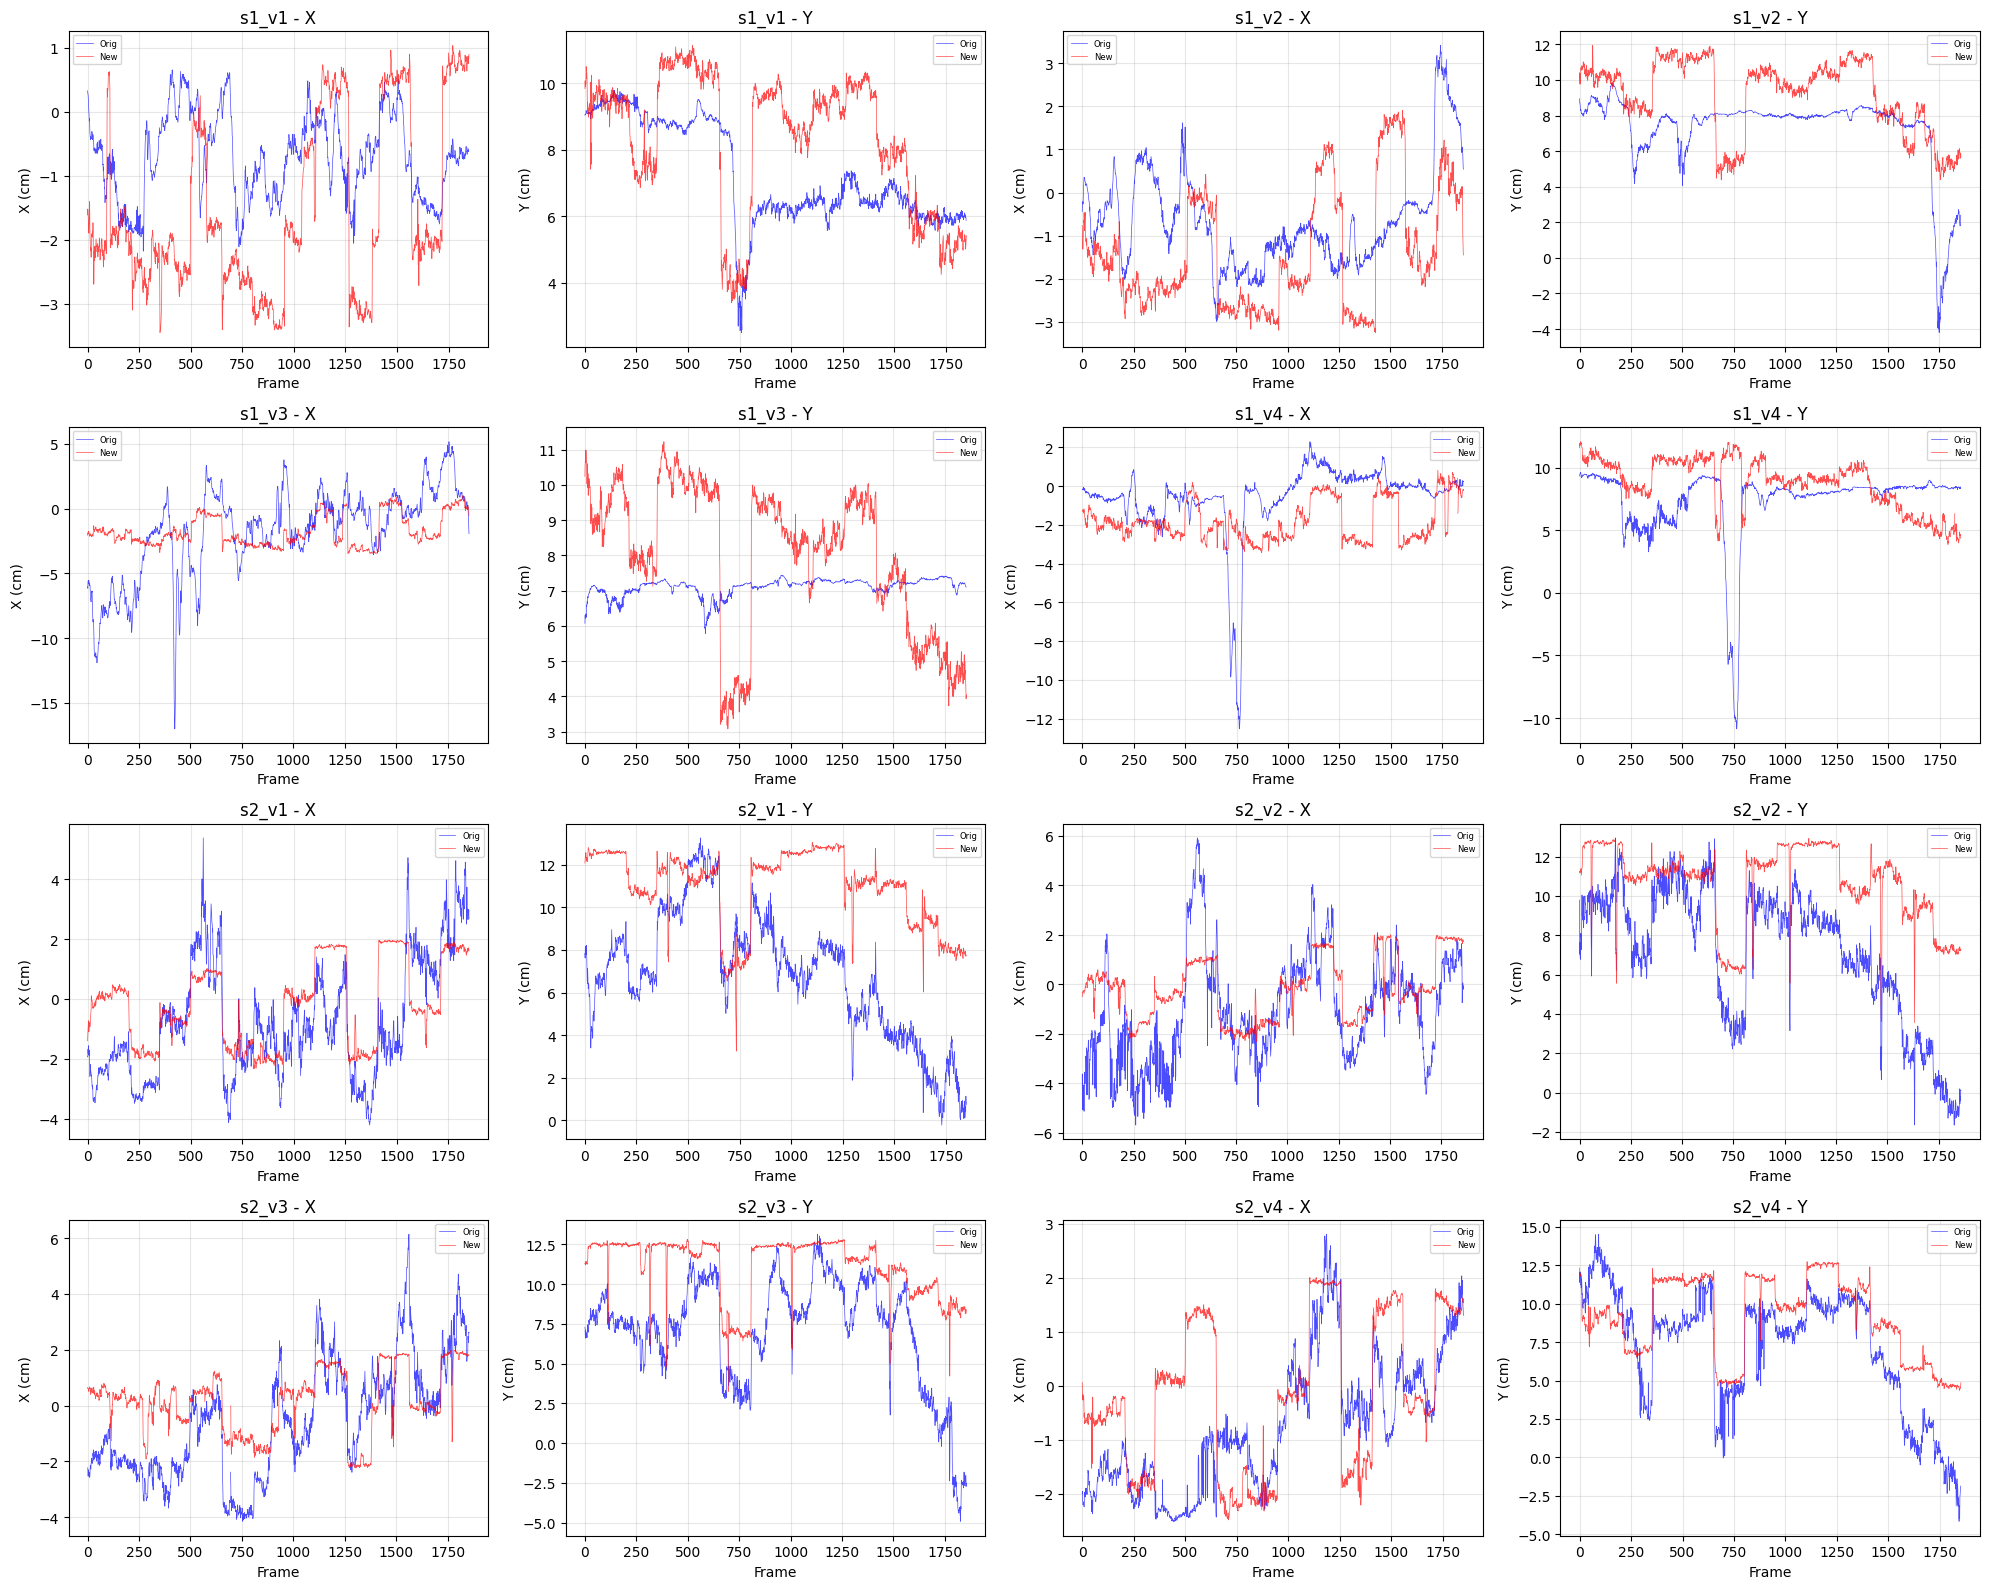

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for idx, video in enumerate(df['video'].unique()):
    subset = df[df['video'] == video].sort_values('frame')
    row = idx // 2
    col = (idx % 2) * 2
    
    # X plot
    ax = axes[row, col]
    ax.plot(subset['frame'], subset['orig_x'], 'b-', alpha=0.7, linewidth=0.5, label='Orig')
    ax.plot(subset['frame'], subset['new_x'], 'r-', alpha=0.7, linewidth=0.5, label='New')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X (cm)')
    ax.set_title(f'{video} - X')
    ax.legend(fontsize=6)
    ax.grid(True, alpha=0.3)
    
    # Y plot
    ax = axes[row, col+1]
    ax.plot(subset['frame'], subset['orig_y'], 'b-', alpha=0.7, linewidth=0.5, label='Orig')
    ax.plot(subset['frame'], subset['new_y'], 'r-', alpha=0.7, linewidth=0.5, label='New')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'{video} - Y')
    ax.legend(fontsize=6)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'all_videos_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

## 2D Scatter: POG Positions

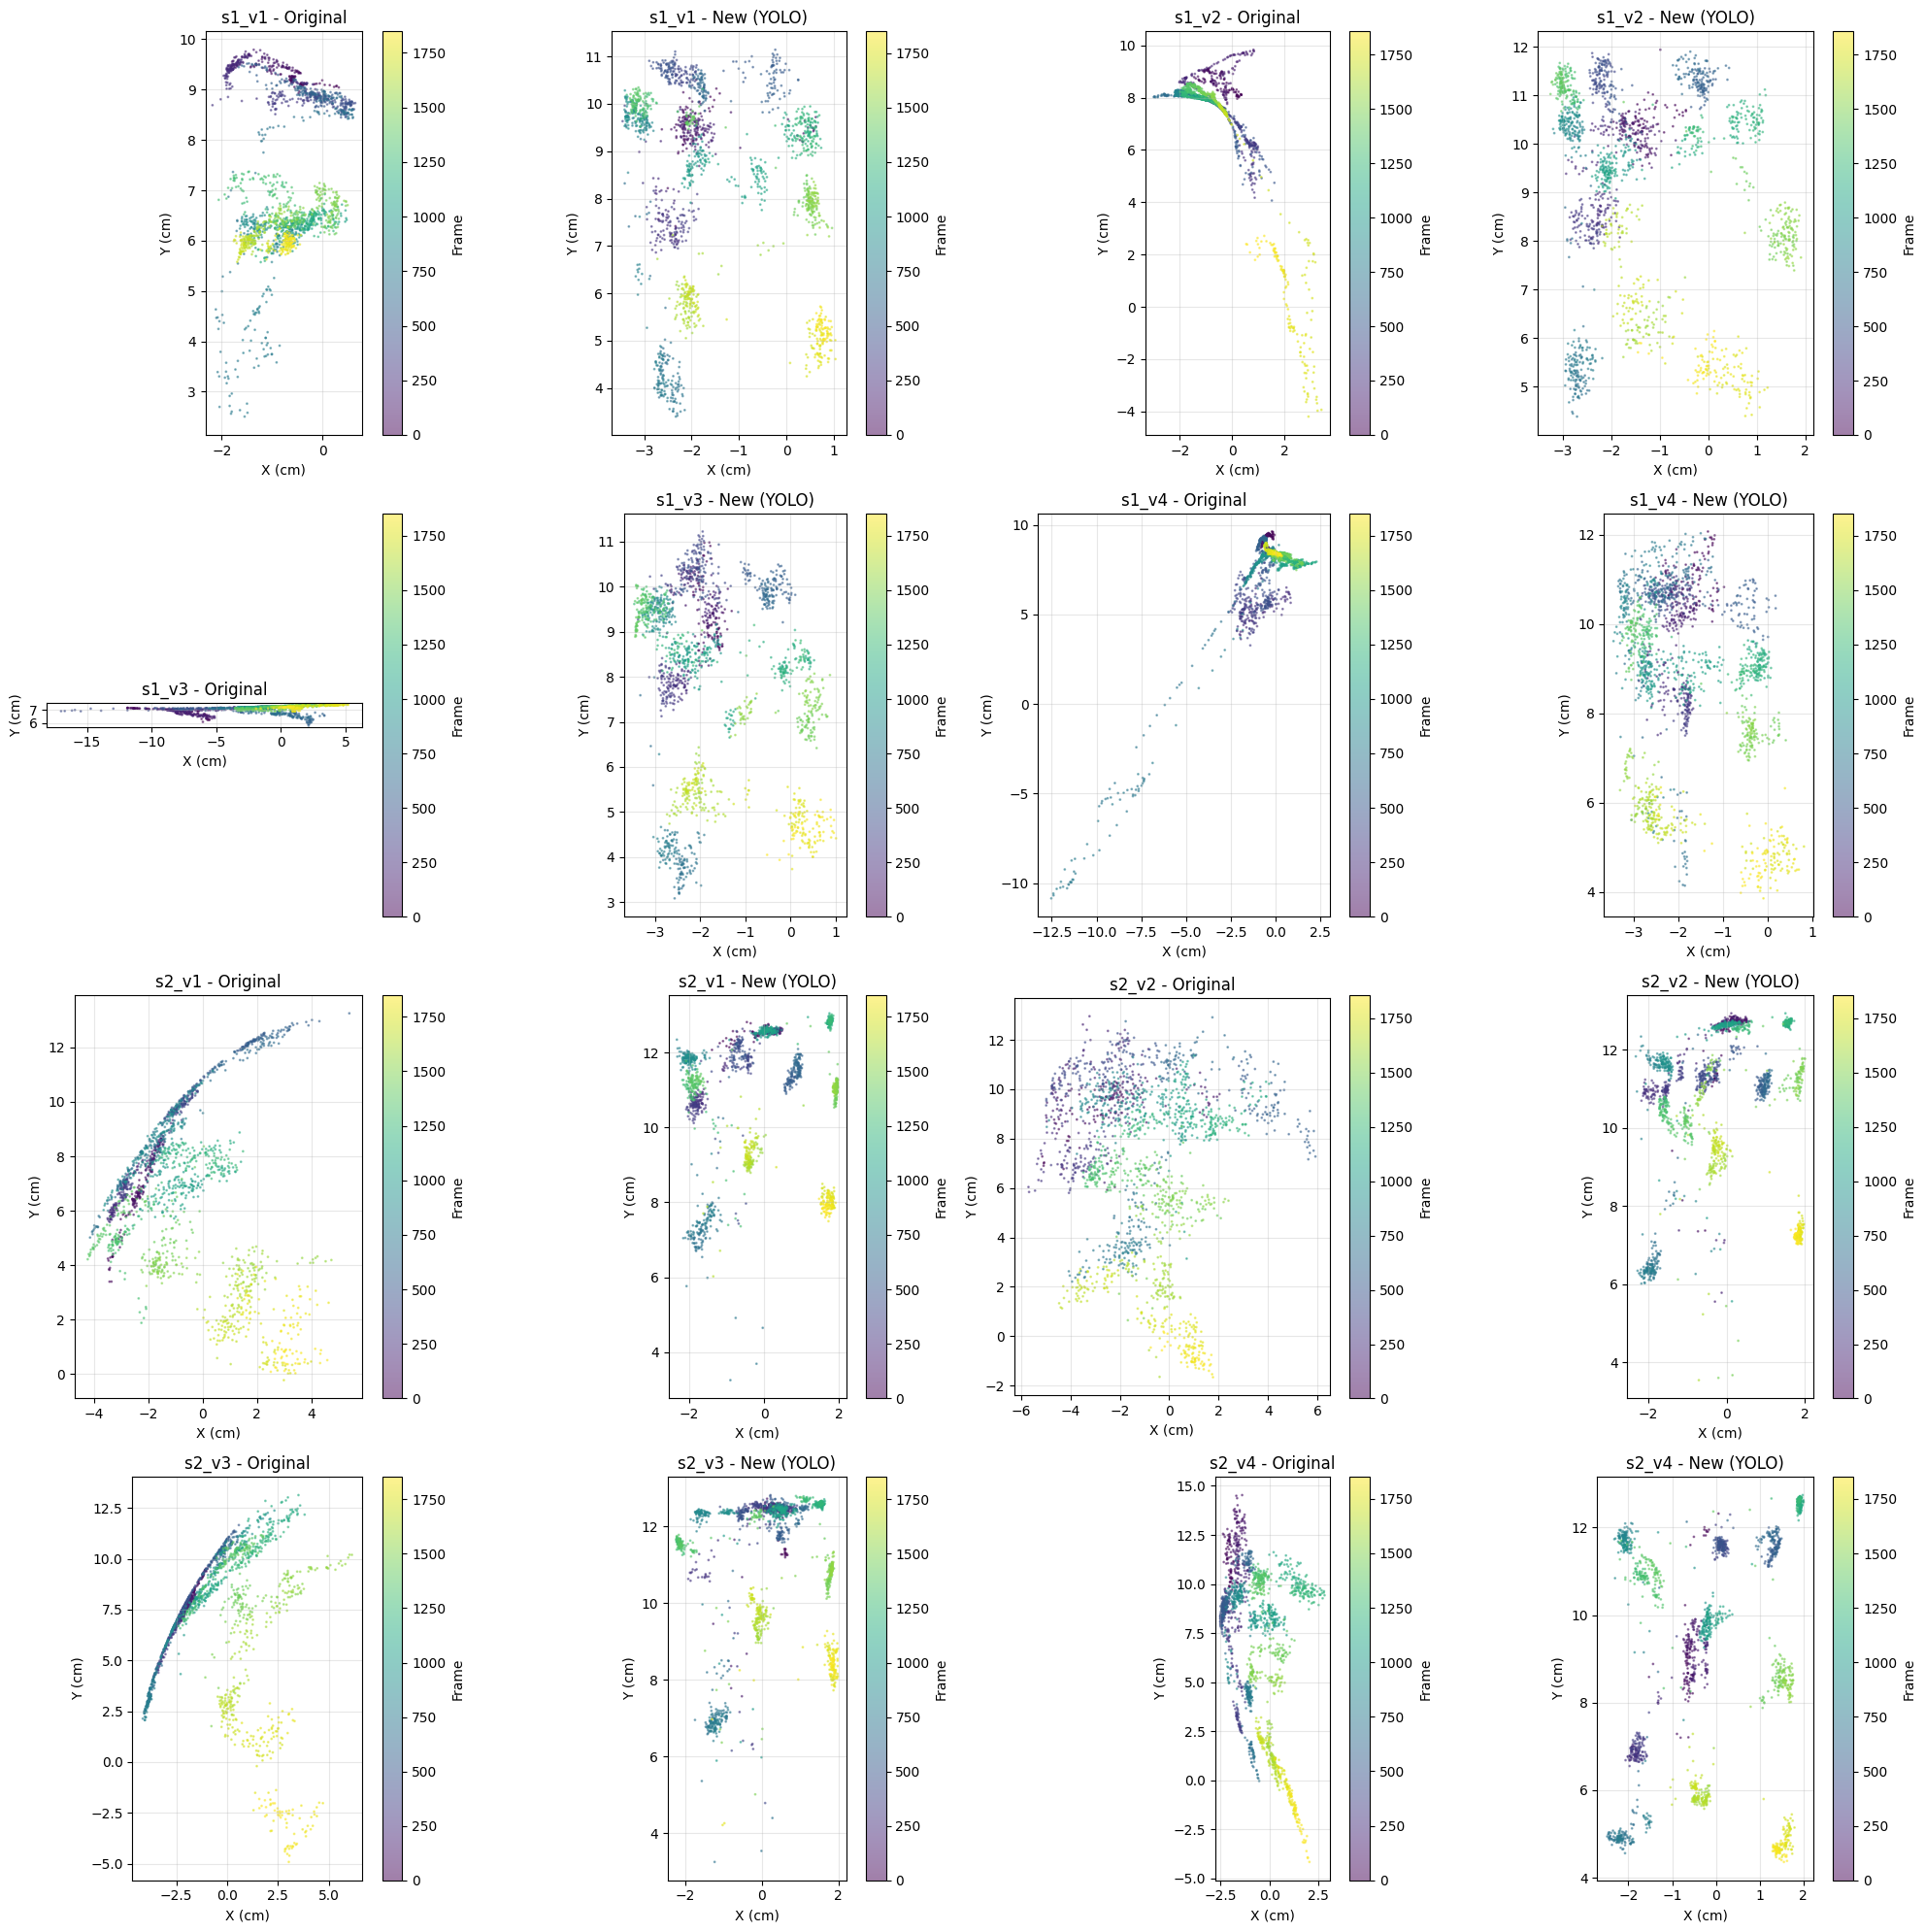

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for idx, video in enumerate(df['video'].unique()):
    subset = df[df['video'] == video]
    row = idx // 2
    col = (idx % 2) * 2
    
    # Original
    ax = axes[row, col]
    valid = subset['orig_x'].notna()
    sc = ax.scatter(subset.loc[valid, 'orig_x'], subset.loc[valid, 'orig_y'],
                    c=subset.loc[valid, 'frame'], cmap='viridis', s=1, alpha=0.5)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'{video} - Original')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    plt.colorbar(sc, ax=ax, label='Frame')
    
    # New
    ax = axes[row, col+1]
    valid = subset['new_x'].notna()
    sc = ax.scatter(subset.loc[valid, 'new_x'], subset.loc[valid, 'new_y'],
                    c=subset.loc[valid, 'frame'], cmap='viridis', s=1, alpha=0.5)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'{video} - New (YOLO)')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    plt.colorbar(sc, ax=ax, label='Frame')

plt.tight_layout()
plt.savefig(OUT_DIR / 'all_videos_2d_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Correlation: Original vs New

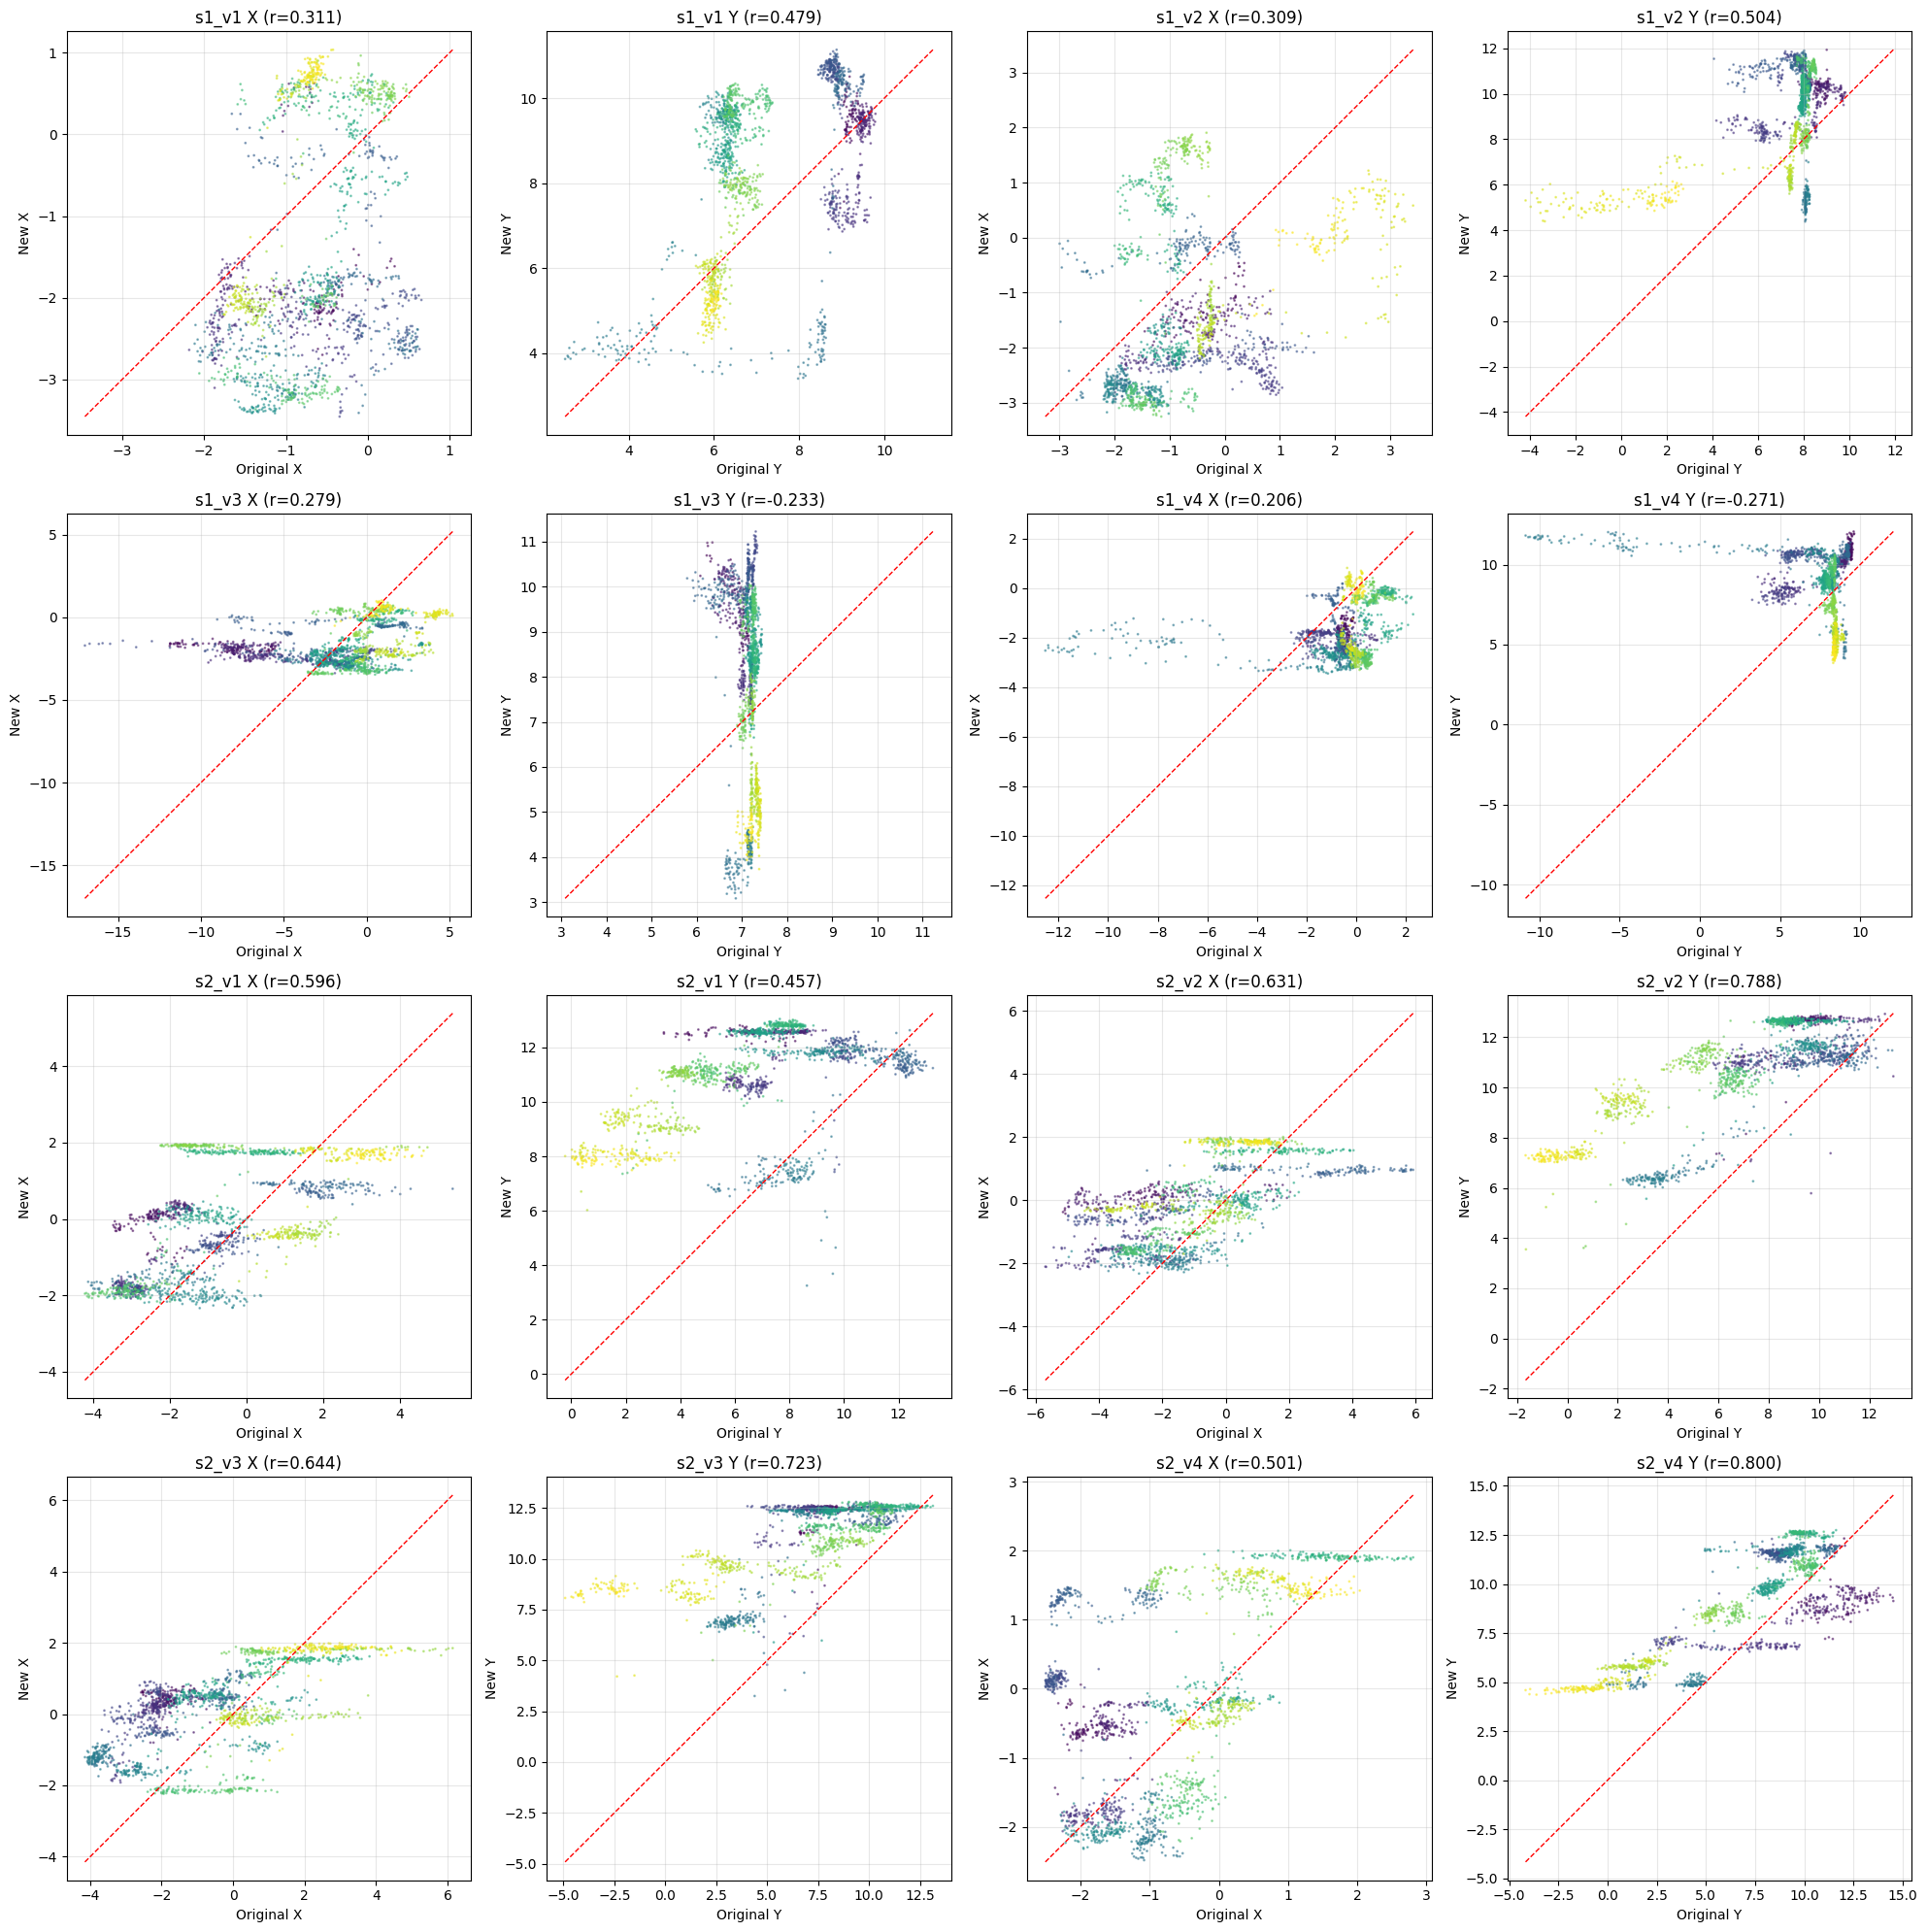

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for idx, video in enumerate(df['video'].unique()):
    subset = df[df['video'] == video]
    valid = subset['orig_x'].notna() & subset['new_x'].notna()
    row = idx // 2
    col = (idx % 2) * 2
    
    # X correlation
    ax = axes[row, col]
    ax.scatter(subset.loc[valid, 'orig_x'], subset.loc[valid, 'new_x'],
               c=subset.loc[valid, 'frame'], cmap='viridis', s=1, alpha=0.5)
    lims = [min(subset.loc[valid, 'orig_x'].min(), subset.loc[valid, 'new_x'].min()),
            max(subset.loc[valid, 'orig_x'].max(), subset.loc[valid, 'new_x'].max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    corr = subset.loc[valid, ['orig_x', 'new_x']].corr().iloc[0,1]
    ax.set_xlabel('Original X')
    ax.set_ylabel('New X')
    ax.set_title(f'{video} X (r={corr:.3f})')
    ax.grid(True, alpha=0.3)
    
    # Y correlation
    ax = axes[row, col+1]
    ax.scatter(subset.loc[valid, 'orig_y'], subset.loc[valid, 'new_y'],
               c=subset.loc[valid, 'frame'], cmap='viridis', s=1, alpha=0.5)
    lims = [min(subset.loc[valid, 'orig_y'].min(), subset.loc[valid, 'new_y'].min()),
            max(subset.loc[valid, 'orig_y'].max(), subset.loc[valid, 'new_y'].max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    corr = subset.loc[valid, ['orig_y', 'new_y']].corr().iloc[0,1]
    ax.set_xlabel('Original Y')
    ax.set_ylabel('New Y')
    ax.set_title(f'{video} Y (r={corr:.3f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'all_videos_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## Histogram: X/Y Distributions

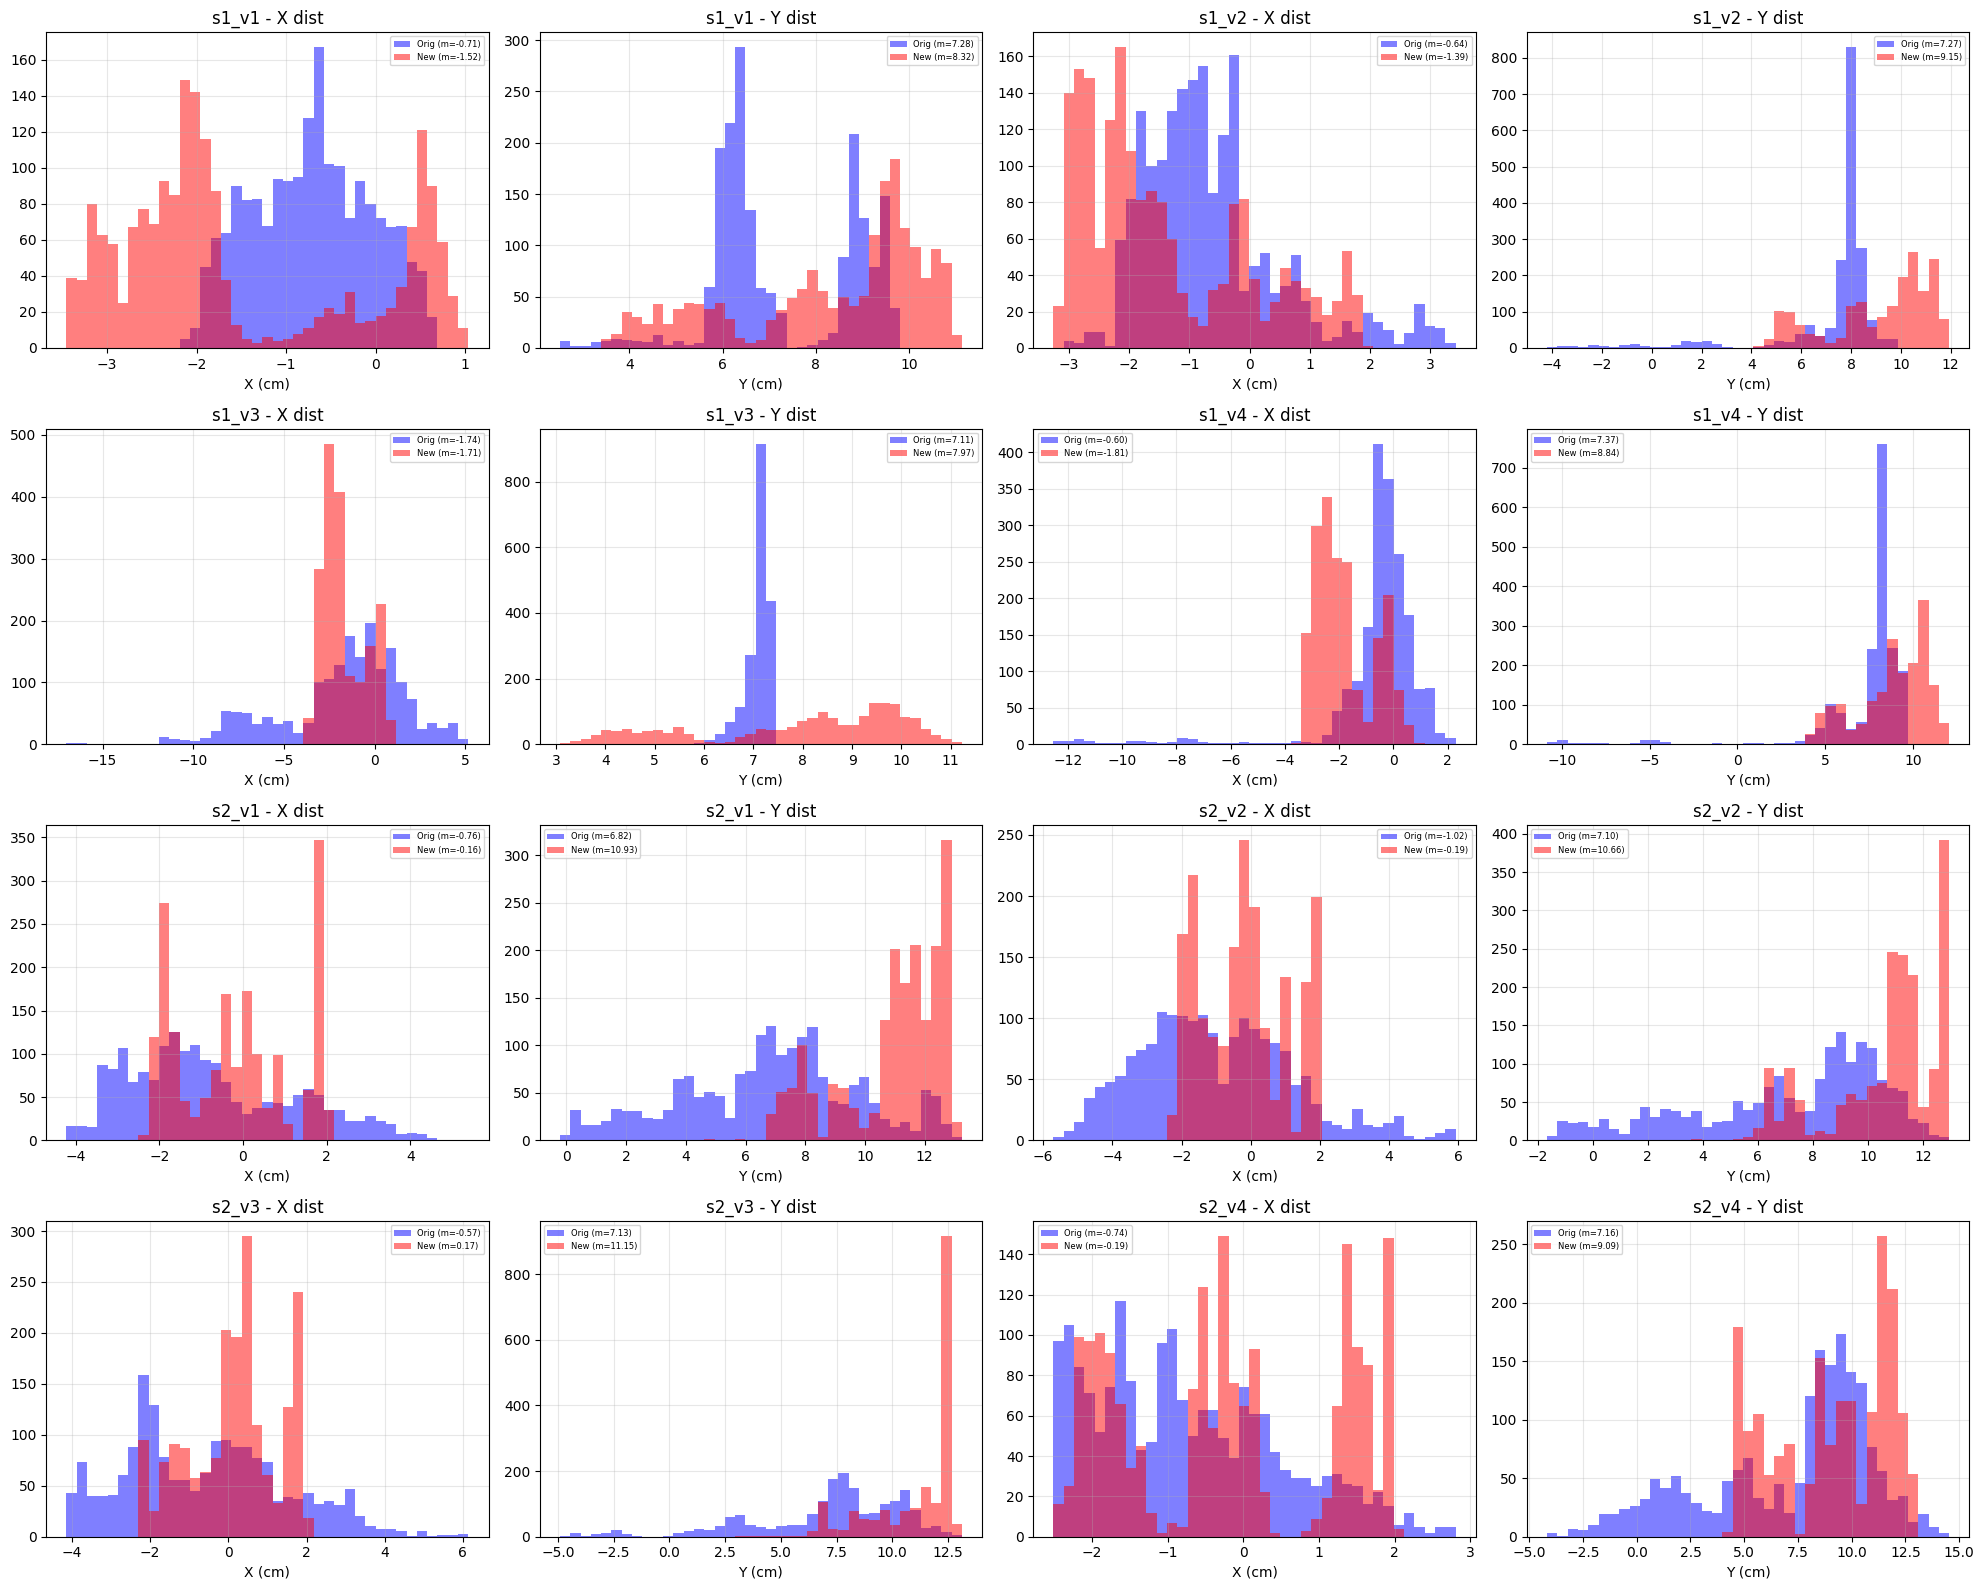

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for idx, video in enumerate(df['video'].unique()):
    subset = df[df['video'] == video]
    row = idx // 2
    col = (idx % 2) * 2
    
    # X histogram
    ax = axes[row, col]
    orig_x = subset['orig_x'].dropna()
    new_x = subset['new_x'].dropna()
    bins = np.linspace(min(orig_x.min(), new_x.min()), max(orig_x.max(), new_x.max()), 40)
    ax.hist(orig_x, bins=bins, alpha=0.5, label=f'Orig (m={orig_x.mean():.2f})', color='blue')
    ax.hist(new_x, bins=bins, alpha=0.5, label=f'New (m={new_x.mean():.2f})', color='red')
    ax.set_xlabel('X (cm)')
    ax.set_title(f'{video} - X dist')
    ax.legend(fontsize=6)
    ax.grid(True, alpha=0.3)
    
    # Y histogram
    ax = axes[row, col+1]
    orig_y = subset['orig_y'].dropna()
    new_y = subset['new_y'].dropna()
    bins = np.linspace(min(orig_y.min(), new_y.min()), max(orig_y.max(), new_y.max()), 40)
    ax.hist(orig_y, bins=bins, alpha=0.5, label=f'Orig (m={orig_y.mean():.2f})', color='blue')
    ax.hist(new_y, bins=bins, alpha=0.5, label=f'New (m={new_y.mean():.2f})', color='red')
    ax.set_xlabel('Y (cm)')
    ax.set_title(f'{video} - Y dist')
    ax.legend(fontsize=6)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'all_videos_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

## Difference Distribution by Video

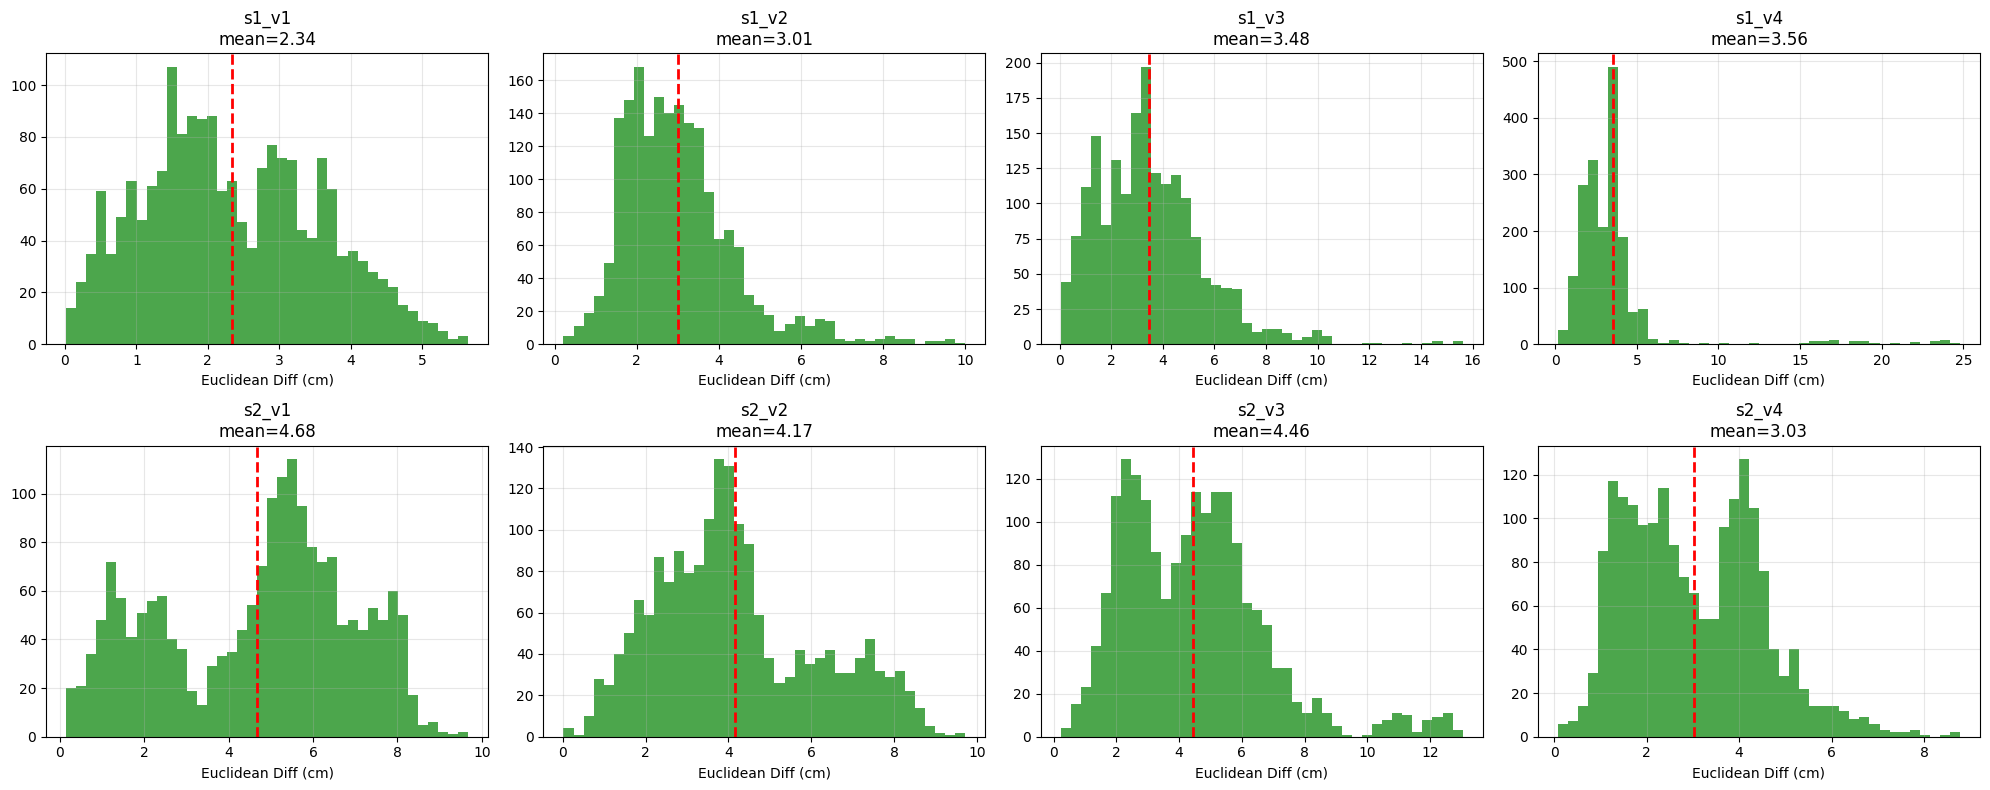

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for idx, video in enumerate(df['video'].unique()):
    subset = df[df['video'] == video]
    valid = subset['diff_euclidean'].notna()
    row = idx // 4
    col = idx % 4
    
    ax = axes[row, col]
    diff = subset.loc[valid, 'diff_euclidean']
    ax.hist(diff, bins=40, alpha=0.7, color='green')
    ax.axvline(diff.mean(), color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Euclidean Diff (cm)')
    ax.set_title(f'{video}\nmean={diff.mean():.2f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'all_videos_diff_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary by Session

In [10]:
# Session-level summary
df['session'] = df['video'].str[:2]

session_summary = []
for session in ['s1', 's2']:
    subset = df[df['session'] == session]
    valid = subset['diff_euclidean'].notna()
    
    session_summary.append({
        'Session': session,
        'Videos': subset['video'].nunique(),
        'Total frames': len(subset),
        'Valid pairs': valid.sum(),
        'Orig X mean': subset['orig_x'].mean(),
        'New X mean': subset['new_x'].mean(),
        'X diff mean': subset.loc[valid, 'diff_x'].mean(),
        'Orig Y mean': subset['orig_y'].mean(),
        'New Y mean': subset['new_y'].mean(),
        'Y diff mean': subset.loc[valid, 'diff_y'].mean(),
        'Eucl diff mean': subset.loc[valid, 'diff_euclidean'].mean(),
        'X correlation': subset.loc[valid, ['orig_x', 'new_x']].corr().iloc[0,1],
        'Y correlation': subset.loc[valid, ['orig_y', 'new_y']].corr().iloc[0,1],
    })

session_df = pd.DataFrame(session_summary)
print('\nSession Summary:')
print(session_df.round(3).to_string(index=False))


Session Summary:
Session  Videos  Total frames  Valid pairs  Orig X mean  New X mean  X diff mean  Orig Y mean  New Y mean  Y diff mean  Eucl diff mean  X correlation  Y correlation
     s1       4          7418         7413       -0.923      -1.609       -0.686        7.257       8.572        1.317           3.095          0.225          0.132
     s2       4          7418         7414       -0.773      -0.093        0.680        7.051      10.458        3.408           4.084          0.583          0.659


## Save Results

In [11]:
# Save merged data
df.to_parquet(OUT_DIR / 'all_videos_merged.parquet', index=False)
print(f'Saved merged data: {OUT_DIR}/all_videos_merged.parquet')
print(f'Shape: {df.shape}')

# Save summary
summary_df.to_csv(OUT_DIR / 'all_videos_summary.csv', index=False)
print(f'Saved summary: {OUT_DIR}/all_videos_summary.csv')

Saved merged data: /media/a/saw/pogclaude/all_videos_merged.parquet
Shape: (14836, 10)
Saved summary: /media/a/saw/pogclaude/all_videos_summary.csv
